In [98]:
##import all the required libraries
import pandas as pd
import numpy as np
import unicodedata
import nltk
import seaborn as sns
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from gensim.models import word2vec
from sklearn import manifold
import itertools
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim import models
from gensim import similarities

In [99]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [100]:
train = pd.read_csv("data/resep_dataset2.csv")
train.Bahan.head()

0    Ayam, potong jadi 10 bagian  -  900 gram Garam...
1    Tepung tapioka  -  150 gram Tepung terigu  -  ...
2    Kangkung  -  1 ikat Kacang panjang  -  1 ikat ...
3    Kuning telur  -  4 butir Minyak goreng  -  40 ...
4    Telur  -  4 butir Gula pasir  -  70 gram Emuls...
Name: Bahan, dtype: object

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Judul   1353 non-null   object
 1   Url     1353 non-null   object
 2   Bahan   1353 non-null   object
 3   Step    1353 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


In [102]:
def clean_number(text):
    text = re.sub(r'\w*\d+\w*', '', str(text))
    return text

In [103]:
#casefolding
def token_lower(text):
    text = ''.join(str(text)).lower() # lowercase text
    return text

#Remove Puncutuation
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')
def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    return text

#menghapus double atau lebih whitespace
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")


In [104]:
#stopword
#clean stopwords
stopwords_indonesian = set(stopwords.words('indonesian'))
# Hapus kata "tahu" dari daftar stopwords
stopwords_indonesian.discard("tahu")

takaran = ['gram', 'sdt', 'sdm', 'buah', 'ml', 'mililiter', 'cup', 'gelas', 'tsp', 'tbsp', 'liter', 'g', 'kg',
           'kilogram', 'pound', 'ons', 'pint', 'pt', 'c', 'celcius', 'f', 'fahrenheit', 'derajat', 'm', 'meter',
           'mm', 'milimeter', 'ruas', 'cm', 'centimeter', 'senti', 'centi', 'siung', 'lembar', 'tangkai', 'batang',
           'butir', 'slice', 'keping', 'kotak', 'papan', 'genggam', 'sejumput', 'bungkus', 'sachet', 'dcc', 'piring',
           'cincin', 'grambahan', 'sendok', 'porsi', 'kantung', 'kantong', 'scoop', 'skup', 'scop', 'loyang', 'segenggam',
           'buntil', 'ikat', 'double', 'botol', 'pack', 'siung','diameter', 'ekor', 'kuntum', 'bonggol']

word_to_remove = [ "a", "acting", "adaan", "adon", "aduk", "air", "alas", "aluminium", "ambil", "ampas", "aneka", "anti",
                  "api" "arik", "asap", "ayak", "b", "bagi", "bagus", "bahan", "bakar", "baluran", "bambu", "bantu", "basah", "basic", 
                  "batangsaus", "belah", "beli", "bening", "bentuk", "berat", "bersih", "berseta", "beserta" "biar", "bilas", 
                  "blender", "bola", "buahbahan", "buahsaus", "buahlainnya", "buahkuah", "buahpencelup", "buang", "bulat", 
                  "bunda", "butir", "butirkuah", "bumbu", "cabut", "cacah", "cair", "cairkan", "campur", "celup", "cepat", 
                  "cetak", "cincang", "cocolan", "cuci", "dadu", "dasar", "diam", "dibagi", "dibentuk" "didih",  "digeprek", 
                  "dingin", "diiikat", "dimemarkan", "dipulung", "direbus", "disangrai", "diseduh", "ditorch", "duri", 
                  "ekorbumbu", "empuk", "encer", "encerkan", "endapan", "es", "fillet", "filling", "foil", "formula", "garam", 
                  "garnish", "gepeng", "geprak", "geprek", "gigi", "gramisi", "gramlapisan", "gramtaburan", "gula", "gurih", 
                  "goreng", "goyang", "hancur", "hangat", "hangatkan", "halus", "hasil", "hias", "i", "ii", "iii", "iv", "ikat", 
                  "instan", "iris", "isi", "jala", "jam", "jari", "jaripelengkap", "jenis", "jumput", "k", "kain", "kaku", "kapal", 
                  "kasar", "kasir", "kasur", "kedalam", "kerat", "kerok", "kocok", "kocock", "kondisi", "konsistensi", "korea", 
                  "korek", "kotor", "kuah", "kualitas", "kuku", "kukus", "kulkas", "kupas", "larut", "larutkan", "lauk", "lapis", 
                  "lawan", "lebar", "lebih", "leleh", "lelehkan", "lembarbumbu", "lembarlainnya", "lembarpudding", "lembartaburan", 
                  "lembut", "lengkap", "lengket", "lentur", "lepas", "lidi", "lihat", "lilit", "literlainnya", "luar", "lulur", 
                  "lumat", "lumatkan", "lumur", "lumuran", "makan", "mangkuk", "marinasi", "matang", "mekar", "memar", "memarkan", 
                  "menit", "menggoreng", "mengunkep", "mengungkep", "mentah", "menyemat", "menyerong", "merebus", "mlbahan", "mlisi", 
                  "mlfilling", "mlpelengkap", "mlsaus", "mlsambal", "mltaburan", "mltopping", "minimal", "minyak", "mudah", "oil", 
                  "oles", "olesisian", "opsional", "optional", "orak", "panas", "panggang", "pakai", "pasir", "papanpelapis", "pecah", 
                  "pecel", "pekat", "pembalur", "penuh", "pera", "peras", "perasan", "perasannya", "perlembar", "persannya", "peta", "parut",
                  "petik", "pilih", "pipil", "pisah", "plastik", "potong", "protein", "puter", "putus", "rajang", "rambut", "rasa", 
                  "ready", "rebus", "rebusan" "rekat", "remas", "rendah", "rendam", "resep", "robek", "ruang", "sangrai", "sampai", 
                  "saring", "sebentar", "secukupnya", "secukupnyaes", "secukupnyisi", "secukupnyaisian", "secukupnyatumisan", 
                  "secukupnyalainnya", "secukupnyaperendam", "secukupnyakaldu", "secukupnyabubur", "secukupnyabiang", "secukupnyalapisan", 
                  "sedang", "seduh", "sdtserundeng", "sdtsaus", "sdtbaluran", "sdttopping", "sdtlainnya", "sdtmerebus", "sdtcuko", 
                  "sdtpencelup", "sdtbahan", "sdtgarnish", "sdtsambal", "sdtperendam", "sdttaburan", "sdtolesan", "segar", "seger", 
                  "sejumpuhkuah", "sejumputkulit", "sela", "selam", "semalam", "semalaman", "selera", "serat", "serong", "serut", 
                  "serutan", "sesuai", "setengah", "seujung", "siangi", "sikat", "simpul", "simpukan", "simpulkan", "siram", "sisa", 
                  "sisir", "siungbumbu", "siungpelapis" "sdmisi", "sdmtaburan", "sdmbahan", "sdmcuko", "sdmuleg", "sdmserundeng", "sd", 
                  "sobek", "spread", "suhu", "suir", "suwir", "tabur", "taburan", "tali", "tambah", "tangan", "tahan", "tbmsp", "tebal", 
                  "tengah", "tetes", "tetessaus", "tinggi", "tintanya", "tipis", "tiris", "tlapisan", "to", "topping", "torch", "tua", "tumbuk", 
                  "tumis", "tusuk", "ukur", "ulek", "uleg", "utuh", "variasi", "versi", "wadah", "wajan"
                 ]

def clean_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stopwords_indonesian and
                     word.lower() not in takaran and word.lower() not in word_to_remove]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

In [105]:
import simplemma
def lemmatization(text):
    text = ' '.join(simplemma.lemmatize(word, lang='id') for word in text.split() if word in text)
    return text 

In [106]:
from nltk.tokenize import word_tokenize

def tokenize_sentence(sentence):
    multi_word_tokens = [
        "abon ayam", "abon sapi", "agar agar", "asam gelugur", "asam jawa", "asam kandis", "asam sunti" "ati ampela", "ati ampela ayam", "ayam kampung", "ayam jantan", 
        "babat sapi", "baby buncis", "baby cumi", "baby kailan", "baby kol",  "baby potato", "bakso ayam", "bakso sapi", "baking soda", "bawang bombay", 
        "bawang bombai", "bawang merah", "bawang putih", "bawang putih bubuk", "baking powder", "bawang prei", "belimbing sayur", "belimbing wuluh", 
        "beras jagung", "beras ketan putih", "beras basmati", "beras ketan", "biji selasih", "biskuit susu", "biskuit oreo", "biskuit marie regal", "bread crumbs", "bread improver",
        "brown sugar", "buah cherry", "buah naga", "buah naga merah", "bubuk spekuk", "bubuk kari", "bunga cengkeh", "bunga genjer", "bunga kecombrang", "bunga lawang", 
        "bunga kol", "bunga sedap malam", "bunga pepaya", "buntut sapi", "butter cream", "cabai merah", "cabai merah besar", "cabai merah keriting", 
        "cabai rawit", "cabai rawit merah", "cabai rawit hijau",  "cabai bubuk", "cabai hijau", "cabai hijau besar", "cake emulsifier", "cabe keriting", 
        "cabai keriting", "cakalang fufu", "ceker ayam", "cheese spread", "chia seed", "choco chips", "coklat bubuk", "cokelat bubuk", "coklat putih",  "chicken katsu", 
        "corn syrup", "cooking cream", "crab stick", "cream cheese", "cream of tartar", "cumi cumi", "daging ayam", "dada ayam", "daging giling", "daging ikan", "daging kambing", "daging sapi", 
        "daging sapi sandung lamur", "daging sapi has dalam", "daun bawang", "daun bayam", "daun cengkeh", "daun cincau", "daun bawang", "daun jeruk", "daun jeruk purut", "daun kari", "daun katuk", 
        "daun kemangi", "daun kol", "daun kunyit", "daun ketumbar", "daun melinjo", "daun mint", "daun pala", "daun pandan", "daun pepaya", "daun pisang", "daun salam", "daun selada", "daun seledri", 
        "daun serai" "daun singkong", "english muffin", "es batu", "essence vanilla", "french fries", "gabin tawar", "gula aren", "gula bubuk", "gula merah", "green tea", "hati sapi", "ice cream", "iga kambing", 
        "iga sapi", "ikan nila", "ikan kembung", "ikan mujair", "ikan mas", "ikan bandeng", "ikan selar", "ikan teri", "ikan gabus", "ikan patin", "ikan tuna", "ikan tongkol", "ikan cakalang", "ikan salmon", 
        "ikan salai", "ikan lele", "ikan gurame", "ikan kakap", "ikan tenggiri", "ikan bawal", "ikan kerapu", "ikan peda", "ikan salem", "ikan asin", "ikan dori", 
        "ikan pe", "jambal roti", "jamur kancing", "jamur kuping",  "jamur hioko", "jamur enoki", "jamur shitake", "jamur champignon", "jamur tiram", "jamur merang", "jambu air", 
        "jantung pisang", "jeruk nipis", "jeruk limau", "jeroan kambing", "jeruk kasturi", "jeruk purut", "jambu air", "jambu biji merah",  "jambu biji", "jeroan sapi", "kacang tanah", 
        "kayu manis",  "kaldu ayam",  "kaldu ayam bubuk", "kaldu bubuk", "kaldu jamur", "kaldu jamur bubuk",  "kaldu sapi", "kaldu udang", "kacang almond", "kacang hijau", "kacang merah", 
        "kacang mede", "kacang kapri", "kacang kedelai", "kacang kenari", "kacang tanah", "kacang panjang", "kacang polong", "kaki kambing", "kaki sapi", "kapur sirih", "kayu manis", "kerang dara", 
        "kembang tahu", "kembang turi", "kecap manis", "kecap ikan", "ketan hitam", "kelapa parut",  "kecap inggris", "kecap asin", "keju cheddar", "keju edam", "keju parmesan", 
        "keju slice", "keju spread", "keju mozarella", "kerang hijau", "kerupuk kanji", "kerupuk krecek", "kerupuk kulit", "kerupuk merah", "kerupuk udang", "kelapa muda", "kembang turi", "kental manis", 
        "kentang goreng", "ketumbar bubuk", "kikil sapi", "kulit pangsit", "kulit lumpia", "kuning telur", "kulit melinjo", "kulit pastry", "kol putih", "kol ungu", "kol merah", "kolang kaling", "krim whipping", 
        "krimer kental manis", "labu kuning", "labu siam", "lada bubuk", "lemak sapi", "lemon cui", "lidah buaya", "lidah sapi", "lobak putih", "mangga kweni", "matcha powder", "melinjo merah", "melinjo hijau", 
        "merica bubuk", "mie kuning", "nasi putih", "nasi shirataki", "nata de coco", "paha ayam", "pala bubuk", "palm sugar", "paprika hijau", "paprika kuning", "paprika merah", "pasta coklat", "pasta mocca", "paru sapi", "petis udang", "pindang tongkol", "pisang ambon", 
        "pisang candi", "pisang kapok", "pisang kepok", "pisang klutuk", "pisang lilin", "pisang mas", "pisang raja", "pisang tanduk", "pisang uli", "putih telur", "quaker oat", "ragi instant", "rice noodles", "roti burger", "roti john", 
        "roti tawar", "rumput laut", "santan instan", "sayap ayam", "sagu mutiara", "sambal terasi", "sandung lamur", "saus sambal", "saus tartar", "saus tomat", "saus tiram", "sawi putih", "selai coklat", 
        "selai coklat", "selai strawberry", "selai kacang", "selai nanas", "smoked beef", "soda kue", "soft cream", "sosis ayam", "sosis sapi", "star anise", "susu bubuk", "susu cair", "susu evaporasi", 
        "susu full cream", "susu kedelai", "susu kental manis", "susu uht", "susu sapi", "tahu cina", "tahu coklat", "tahu gembos", "tahu jepang", "tahu kuning", "tahu kulit", "tahu putih", 
        "tahu pong", "tahu sutra", "tahu sumedang", "tape ketan", "tape singkong", "tape ketan hitam", "tetelan sapi", "telur asin", "telur ayam", "telur bebek", "telur ikan", 
        "telur puyuh", "temu kunci", "tepung beras", "tepung hunkwe", "teri nasi", "tepung kanji", "tepung ketan", "tepung ketan putih", "tepung panir", "tepung roti", "tepung sagu", 
        "tepung tapioka", "tepung terigu", "tepung maizena", "teri nasi medan", "teri medan", "timun suri", "timun jepang" "tomat merah", "tomat hijau", "tulang ayam", "tulang daging", "tulang kambing", 
        "tulang kaki sapi", "tulang jambal roti", "tulang rangu", "ubi merah", "ubi ungu", "ubi cilembu", "ubi jalar", "ubi kuning", "ubi orange", "unsalted butter", "usus ayam", "urat sapi", "whipping cream", "wijen sangrai"
    ]
    
    # Replace multi-word tokens with versions that have spaces
    for token in multi_word_tokens:
        space_removed_token = token.replace(" ", "")
        sentence = sentence.replace(space_removed_token, token)

    # Tokenize the sentence based on spaces
    words = sentence.split()

    # Create tokens by combining two and three consecutive words
    combined_tokens = []
    i = 0
    while i < len(words):
        two_word_token = " ".join(words[i:i+2])
        three_word_token = " ".join(words[i:i+3])

        if three_word_token in multi_word_tokens:
            combined_tokens.append(three_word_token)
            i += 3
        elif two_word_token in multi_word_tokens:
            combined_tokens.append(two_word_token)
            i += 2
        else:
            combined_tokens.append(words[i])
            i += 1

    # Remove duplicates
    unique_tokens = list(set(combined_tokens))

    return unique_tokens

In [107]:
synonym_mapping = {
        'kubis': 'kol',
        'daun cengkeh': 'ceengkeh',
        'baby kol': 'cuciwis',
        'pekak': 'bunga lawang',
        'kembang lawang': 'bunga lawang',
        'kembang kol': 'bunga kol',
        'bawang bombai': 'bawang bombay',
        'terigu': 'tepung terigu',
        'maizena': 'tepung maizena',
        'tapioka': 'tepung tapioka',
        'kental manis': 'susu kental manis',
        'coklat': 'cokelat',
        'mete': 'kacang mete',
        'almond': 'kacang almond',
        'daun kol': 'kol',
        'daging ayam': 'ayam',
        'selasih': 'biji selasih',
        'agar': 'agar agar',
        'cherry': 'buah cherry',
        'belimbing sayur': 'belimbing wuluh',
        'santan instan': 'santan',
        'star anise': 'bunga lawang',
        'pete': 'petai',
        'bawang prei': 'daun bawang',
        'whipcream': 'whipping cream',
        'laos': 'lengkuas',
        'jeruk kasturi': 'lemon cui',
        'tahu sutra': 'tahu jepang',
        'whip cream': 'whipping cream',
        'daun bayam': 'bayam',
        'pindang tongkol': 'ikan tongkol',
        'tongkol': 'ikan tongkol',
        'sereh': 'serai',
        'daun serai': 'serai',
        'tomat merah': 'tomat',
        'kol ungu': 'kol merah',
        'kemangi': 'daun kemangi',
        'toge': 'tauge',
        'bandeng': 'ikan bandeng',
        'bread crumbs': 'breadcrumbs',
        'bread crumbs': 'tepung roti',
        'es batu': 'es',
        'cakalang fufu': 'ikan cakalang',
        'kyuri': 'timun jepang',
        'ceker': 'ceker ayam',
        'nenas': 'nanas',
        'kacang kapri': 'kapri',
        'daging': 'daging sapi',
        'petai': 'pete'
    }

# Fungsi untuk mencari sinonim dari suatu kata jika tidak ditemukan
def cari_sinonim(kata, synonym_mapping):
    for kunci, nilai in synonym_mapping.items():
        if kata in nilai.split(', '):
            return kunci
    return kata

In [108]:
def bahan_parser(text):
    text = clean_number(text)
    text = token_lower(text)
    text = clean_punct(text)
    text = _normalize_whitespace(text)
    text = lemmatization(text)
    text = clean_stopwords(text)

    # Use the modified tokenize_sentence function
    text = tokenize_sentence(text)

    return text

In [109]:
train['clean'] = train['Bahan'].apply(bahan_parser)

In [110]:
train['clean']

0       [kunyit, bawang putih, bawang merah, andaliman...
1       [cabai bubuk, tepung terigu, kaldu bubuk, sele...
2       [merah, terong, kangkung, cabai merah, tauge, ...
3       [tepung terigu, coklat bubuk, coklat, kuning t...
4       [moka, telur, strawberry, emulsifier, coklat b...
                              ...                        
1348    [telur, tepung terigu, vanili, sp, baking powd...
1349    [daging sapi, ketumbar, kaldu sapi, bawang mer...
1350    [telur, tepung terigu, vanili, baking powder, ...
1351    [tepung terigu, nanas, keju cheddar, butter, k...
1352    [lada, daun ketumbar, alpukat, bawang bombay, ...
Name: clean, Length: 1353, dtype: object

In [111]:
bahan_parser(train.clean[0])

['kunyit',
 'andaliman',
 'bawang merah',
 'laos',
 'putih',
 'jeruk nipis',
 'ayam',
 'cabai rawit merah',
 'kelapa',
 'serai',
 'jahe',
 'daun jeruk',
 'bawang putih']

In [112]:
train

,Judul,Url,Bahan,Step,clean
0,Resep Ayam Panidar,https://resepkoki.id/resep/resep-ayam-panidar/,"Ayam, potong jadi 10 bagian - 900 gram Garam...",Cuci bersih ayam kemudian marinasi dengan gara...,"[kunyit, bawang putih, bawang merah, andaliman..."
1,Resep Moring,https://resepkoki.id/resep/resep-moring/,Tepung tapioka - 150 gram Tepung terigu - ...,"Campur tepung tapioka, terigu, bawang putih, g...","[cabai bubuk, tepung terigu, kaldu bubuk, sele..."
2,Resep Serombotan Klungkung,https://resepkoki.id/resep/resep-serombotan-kl...,Kangkung - 1 ikat Kacang panjang - 1 ikat ...,Rebus masing-masing sayuran dengan sedikit gar...,"[merah, terong, kangkung, cabai merah, tauge, ..."
3,Resep Hurricane Cake Roll,https://resepkoki.id/resep/resep-hurricane-cak...,Kuning telur - 4 butir Minyak goreng - 40 ...,"Bahan 1: Campur kuning telur dan susu cair, ad...","[tepung terigu, coklat bubuk, coklat, kuning t..."
4,Resep Bolu Gulung Batik,https://resepkoki.id/resep/resep-bolu-gulung-b...,Telur - 4 butir Gula pasir - 70 gram Emuls...,"Kocok telur, gula pasir dan emulsifier sampai ...","[moka, telur, strawberry, emulsifier, coklat b..."
...,...,...,...,...,...
1348,Resep Bolu Panggang Coklat,https://resepkoki.id/resep/resep-bolu-panggang...,Tepung terigu - 150 gram Baking powder - ...,Jadikan 1 semua bahan A dan ayak. Sisihkan.Sia...,"[telur, tepung terigu, vanili, sp, baking powd..."
1349,Resep Dendeng Batokok,https://resepkoki.id/resep/resep-dendeng-batokok/,Air kelapa - 700 ml Daging sapi - 350 gra...,"Rebus daging tanpa di potong, dengan bumbu reb...","[daging sapi, ketumbar, kaldu sapi, bawang mer..."
1350,Resep Kue Cubit,https://resepkoki.id/resep/resep-kue-cubit/,Tepung terigu protein rendah - 100 gram Rag...,"Campurkan semua bahan A, lalu aduk dengan spat...","[telur, tepung terigu, vanili, baking powder, ..."
1351,Resep Kue Nastar Keju,https://resepkoki.id/resep/resep-kue-nastar-keju/,Tepung terigu protein sedang - 350 gram Sus...,"Kocok margarin, butter, dan gula halus dengan ...","[tepung terigu, nanas, keju cheddar, butter, k..."


In [113]:
train.to_csv('data/train_clean.csv')

In [114]:
#Code to generate bag of words from the cleaned ingredient list
bags_of_words = [Counter(bahan_parser(Bahan)) for Bahan in train.Bahan]

In [115]:
#Find sum of every ingredient using Counter()
sumbags = sum(bags_of_words, Counter())


# Finally, plot the 10 most used ingredients
clean_df = pd.DataFrame.from_dict(sumbags, orient='index').reset_index()
clean_df = clean_df.rename(columns={'index':'Bahan', 0:'count'})
clean_df.to_csv('data/ingredient_clean.csv')

top_ing = clean_df.sort_values('count', ascending=False)

In [116]:
clean_df

,Bahan,count
0,kunyit,130
1,bawang putih,729
2,bawang merah,467
3,andaliman,4
4,laos,16
...,...,...
933,kaki,1
934,tunjang,1
935,mocca,1
936,essense,1


In [117]:
ingr_only_dict = clean_df['Bahan'].to_dict()

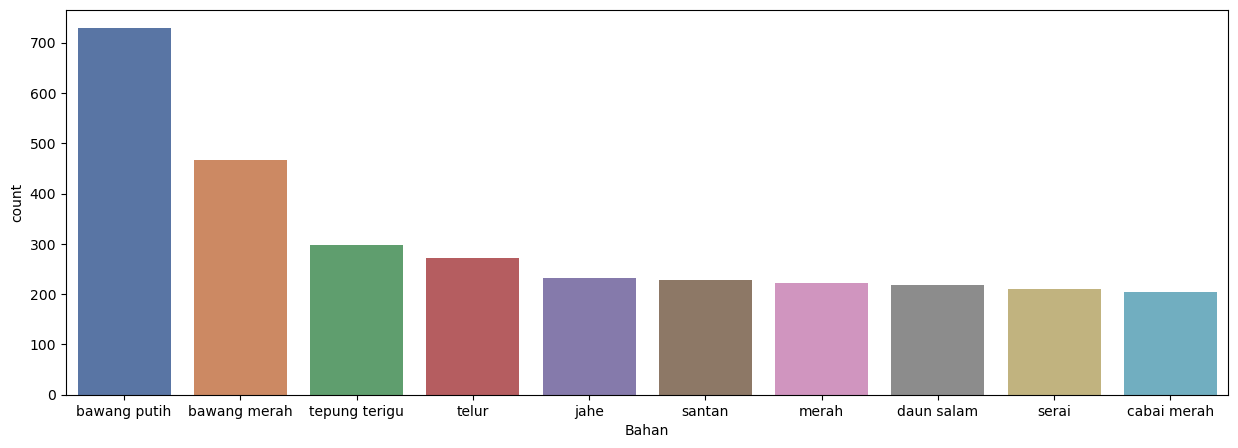

In [118]:
#Plot top ingredients using bag of words
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x = 'Bahan', y = 'count', data = top_ing.head(10))
sns.set_palette("deep")
plt.show()
fig.savefig('ingredient_count_bag_of_words.png')

In [119]:
#Get all clean ingredients in list format per recipe
ingr_list = []
for Bahan in train.Bahan:
    ingr_list.append(bahan_parser(Bahan))

In [120]:
print (ingr_list[0])

['kunyit', 'bawang putih', 'bawang merah', 'andaliman', 'laos', 'putih', 'jeruk nipis', 'ayam', 'cabai rawit merah', 'kelapa', 'jahe', 'daun jeruk', 'serai']


In [121]:
#PMI Calculation starts
#Point-wise mutual information to understand which ingredients go together and which ones don't

#Create combinations of ingredients
start_time = time.time()

l = []
for K in range(len(ingr_list)):
    for L in range(2,3):
        for subset in itertools.combinations(ingr_list[K], L):
            l.append(sorted(subset))       
#print("--- %s seconds ---" % (time.time() - start_time))

In [122]:
print (l[0])

['bawang putih', 'kunyit']


In [123]:
#Function - Point-wise mutual information
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [124]:
#Convert list of tuples to dataframe
df = pd.DataFrame(l, columns = ['Ingredient1','Ingredient2'])
print (df.count())

#Eliminate rows where Ingredient1 = Ingredient2
df = df[df['Ingredient1'] != df['Ingredient2']]
print (df.count())

Ingredient1    67519
Ingredient2    67519
dtype: int64
Ingredient1    67519
Ingredient2    67519
dtype: int64


In [125]:
#Calculate PMI
df = pmi(df, 'Ingredient1', 'Ingredient2')
print(df.count())

Ingredient1    67519
Ingredient2    67519
f_x            67519
f_y            67519
f_xy           67519
pmi            67519
dtype: int64


In [126]:
df

,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
0,bawang putih,kunyit,6580,1063,120,0.147016
1,bawang merah,kunyit,4725,1063,105,0.344651
2,andaliman,kunyit,39,1063,2,1.180899
3,kunyit,laos,382,136,4,1.648383
4,kunyit,putih,382,719,12,1.081789
...,...,...,...,...,...,...
67514,bawang bombay,daun ketumbar,1355,2,1,3.215460
67515,daun ketumbar,tomat,2,1486,1,3.123174
67516,alpukat,bawang bombay,111,40,2,3.414902
67517,alpukat,tomat,111,1486,2,-0.200062


In [127]:
#Eliminate rows for the same ingredient combinations
print (df.pmi.count())
df = df.drop_duplicates()
print (df.pmi.count())

#Sort df
df = df.sort_values('pmi',ascending=False)
df.head()

67519
22843


,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
7579,pulen,selongsong,1,3,1,10.021552
53675,puding,ramekin,3,1,1,10.021552
1245,abon ayam,abon sapi,3,1,1,10.021552
14792,creamer,matcha powder,2,2,1,9.733870
66715,swallow,white,1,6,1,9.328405


In [128]:
df.to_csv('data/pmi_ingredient_similarity.csv', encoding = 'utf-8')

In [129]:
df = pd.read_csv('data/pmi_ingredient_similarity.csv')
df = df.sort_values('pmi',ascending=False)
top_df = df.groupby('Ingredient1').head(5)
top_df.to_csv('data/pmi_ingredient_similarity_top.csv')

df = df.sort_values('pmi',ascending=True)
neg_df = df.groupby('Ingredient1').head(5)
neg_df.to_csv('data/pmi_ingredient_similarity_neg.csv')

In [130]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [131]:
##Get clean ingredients to be used as an input for word2vec model to identify ingredient similarity.

ingr_clean_df = pd.DataFrame({'Bahan':ingr_list})
#print ingr_clean_df
print (ingr_clean_df)
ingr_clean_df.to_csv('data/ingredient_2_recipe_clean.csv')

                                                  Bahan
0     [kunyit, bawang putih, bawang merah, andaliman...
1     [cabai bubuk, tepung terigu, kaldu bubuk, sele...
2     [merah, terong, kangkung, cabai merah, tauge, ...
3     [tepung terigu, coklat bubuk, coklat, kuning t...
4     [moka, telur, strawberry, emulsifier, coklat b...
...                                                 ...
1348  [telur, tepung terigu, vanili, sp, baking powd...
1349  [daging sapi, ketumbar, kaldu sapi, bawang mer...
1350  [telur, tepung terigu, vanili, baking powder, ...
1351  [tepung terigu, nanas, keju cheddar, butter, k...
1352  [lada, daun ketumbar, alpukat, bawang bombay, ...

[1353 rows x 1 columns]


In [132]:
#pip install -U gensim
#Implementing word2vec to get the recipes which are similar to each other
from gensim.models import Word2Vec

# Gabungkan semua list kata menjadi satu list besar
flat_ingr_list = [item for sublist in ingr_list for item in sublist]

# Train the Word2Vec model
num_features = 250  # Word vector dimensionality
context = 1  # Context window size
downsampling = 1e-3  # Threshold for downsampling higher-frequency words
epochs = 95  # Number of training epochs

# Initialize and train the Word2Vec model
model = Word2Vec(sentences=[flat_ingr_list], vector_size=num_features, window=context, sample=downsampling, epochs=epochs)

# Save the trained model
model.save("models/recom.model")



In [133]:
flatten_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flatten_list:
            flatten_list.append(item)

In [134]:
flatten_list

['kunyit',
 'bawang putih',
 'bawang merah',
 'andaliman',
 'laos',
 'putih',
 'jeruk nipis',
 'ayam',
 'cabai rawit merah',
 'kelapa',
 'jahe',
 'daun jeruk',
 'serai',
 'cabai bubuk',
 'tepung terigu',
 'kaldu bubuk',
 'seledri',
 'tepung tapioka',
 'merah',
 'terong',
 'kangkung',
 'cabai merah',
 'tauge',
 'kemiri',
 'kacang tanah',
 'kencur',
 'cabai rawit',
 'kacang',
 'coklat bubuk',
 'coklat',
 'kuning telur',
 'putih telur',
 'moka',
 'telur',
 'strawberry',
 'emulsifier',
 'pasta',
 'susu bubuk',
 'tepung maizena',
 'margarin',
 'daging sapi',
 'lengkuas',
 'daun salam',
 'asam jawa',
 'chocolate',
 'x',
 'kulit pastry',
 'cooking',
 'pandan',
 'dark',
 'maizena',
 'vla',
 'susu full cream',
 'kering',
 'gaplek',
 'singkong',
 'daging ayam',
 'bawang',
 'kayu manis',
 'kentang',
 'tepung',
 'bunga lawang',
 'telur ayam',
 'cengkeh',
 'kapulaga',
 'daun kari',
 'terasi',
 'beras jagung',
 'tahu',
 'ikan asin',
 'tempe',
 'sambal terasi',
 'beras',
 'kental',
 'jus',
 'santan',

In [135]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in flatten_list:
    try: 
        if len(i) > 0:
            #print i
            corpus_sim_dict.update({i:model.wv.similarity(i,i)})      
    except KeyError:
        pass

In [136]:
corpus_sim_dict

{'kunyit': 1.0,
 'bawang putih': 1.0,
 'bawang merah': 1.0,
 'laos': 1.0,
 'putih': 1.0,
 'jeruk nipis': 1.0,
 'ayam': 1.0,
 'cabai rawit merah': 1.0,
 'kelapa': 1.0,
 'jahe': 1.0,
 'daun jeruk': 1.0,
 'serai': 1.0,
 'cabai bubuk': 1.0,
 'tepung terigu': 0.99999994,
 'kaldu bubuk': 1.0,
 'seledri': 0.99999994,
 'tepung tapioka': 1.0,
 'merah': 1.0,
 'terong': 1.0,
 'kangkung': 1.0,
 'cabai merah': 1.0,
 'tauge': 1.0,
 'kemiri': 1.0,
 'kacang tanah': 1.0,
 'kencur': 0.99999994,
 'cabai rawit': 0.99999994,
 'kacang': 1.0,
 'coklat bubuk': 1.0,
 'coklat': 1.0,
 'kuning telur': 1.0,
 'putih telur': 1.0,
 'telur': 1.0,
 'strawberry': 1.0,
 'emulsifier': 0.99999994,
 'pasta': 1.0,
 'susu bubuk': 1.0,
 'tepung maizena': 0.99999994,
 'margarin': 1.0,
 'daging sapi': 1.0,
 'lengkuas': 1.0,
 'daun salam': 1.0,
 'asam jawa': 1.0,
 'chocolate': 1.0,
 'cooking': 1.0,
 'pandan': 1.0,
 'dark': 1.0,
 'maizena': 1.0,
 'susu full cream': 1.0,
 'kering': 1.0,
 'singkong': 1.0,
 'daging ayam': 1.0,
 'bawa

In [137]:
model.wv.most_similar('ayam')

[('ikan', 0.7585957050323486),
 ('bunga kol', 0.7430188655853271),
 ('paha ayam', 0.7180221080780029),
 ('sandung lamur', 0.7073268890380859),
 ('has', 0.6949516534805298),
 ('kepala', 0.6914868950843811),
 ('daging giling', 0.6887132525444031),
 ('sambal terasi', 0.6876459121704102),
 ('daging ayam', 0.670839250087738),
 ('daun seledri', 0.6692146062850952)]

In [138]:
model.wv.most_similar('kol')

[('daun kol', 0.7865909934043884),
 ('daun selada', 0.7740151286125183),
 ('acar', 0.752703070640564),
 ('tahu kulit', 0.7154319286346436),
 ('bakso sapi', 0.7082738280296326),
 ('labu siam', 0.6941653490066528),
 ('cabe', 0.6520531177520752),
 ('tiram', 0.6350256204605103),
 ('bengkuang', 0.6344313025474548),
 ('soun', 0.6308736205101013)]

In [139]:
model.wv.most_similar('keju')

[('choco chips', 0.7685163617134094),
 ('keju mozarella', 0.7138213515281677),
 ('pisang', 0.7113330960273743),
 ('meses', 0.7105362415313721),
 ('ubi ungu', 0.6893810629844666),
 ('dark', 0.6789124011993408),
 ('kepiting', 0.6705496311187744),
 ('olive', 0.6687255501747131),
 ('soda kue', 0.6659916043281555),
 ('pisang ambon', 0.6619693040847778)]

In [140]:
model.wv.most_similar('tepung terigu')

[('baking soda', 0.6933672428131104),
 ('warni', 0.6465217471122742),
 ('sosis', 0.638664186000824),
 ('lontong', 0.6360905170440674),
 ('emulsifier', 0.608453631401062),
 ('bawang putih bubuk', 0.6072224378585815),
 ('cooking', 0.6016784310340881),
 ('butter cream', 0.60160231590271),
 ('kulit pangsit', 0.5984055399894714),
 ('kismis', 0.5890098214149475)]

In [141]:
dictionary = corpora.Dictionary(ingr_list)
#print(dictionary)
print(dictionary.token2id)

{'andaliman': 0, 'ayam': 1, 'bawang merah': 2, 'bawang putih': 3, 'cabai rawit merah': 4, 'daun jeruk': 5, 'jahe': 6, 'jeruk nipis': 7, 'kelapa': 8, 'kunyit': 9, 'laos': 10, 'putih': 11, 'serai': 12, 'cabai bubuk': 13, 'kaldu bubuk': 14, 'seledri': 15, 'tepung tapioka': 16, 'tepung terigu': 17, 'cabai merah': 18, 'cabai rawit': 19, 'kacang': 20, 'kacang tanah': 21, 'kangkung': 22, 'kemiri': 23, 'kencur': 24, 'merah': 25, 'tauge': 26, 'terong': 27, 'coklat': 28, 'coklat bubuk': 29, 'kuning telur': 30, 'putih telur': 31, 'emulsifier': 32, 'margarin': 33, 'moka': 34, 'pasta': 35, 'strawberry': 36, 'susu bubuk': 37, 'telur': 38, 'tepung maizena': 39, 'asam jawa': 40, 'daging sapi': 41, 'daun salam': 42, 'lengkuas': 43, 'chocolate': 44, 'cooking': 45, 'dark': 46, 'kulit pastry': 47, 'maizena': 48, 'pandan': 49, 'susu full cream': 50, 'vla': 51, 'x': 52, 'gaplek': 53, 'kering': 54, 'singkong': 55, 'bawang': 56, 'daging ayam': 57, 'bunga lawang': 58, 'cengkeh': 59, 'daun kari': 60, 'kapulaga'

In [142]:
#Applying doc2bow on the dictionary of ingredients, which converts the ingredient to a number in every recipe
#This input format is needed for TfIdfmodel
bow_corpus = [dictionary.doc2bow(text) for text in ingr_list]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [143]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [144]:
def get_and_sort_corpus(data):
    corpus_sorted = []
    for doc in data.parsed.values:
        sorted_doc = sorted(doc)
        corpus_sorted.append(sorted_doc)
    return corpus_sorted

In [145]:
from collections import defaultdict

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Fungsi untuk mencari resep berdasarkan kata kunci
def cari_resep(kata_kunci, resep_dict, synonym_mapping):
    kata_kunci = kata_kunci.lower()
    
    # Mencari sinonim kata kunci
    kata_kunci_sinonim = [synonym_mapping.get(kata, kata) for kata in kata_kunci.split()]

    resep_cocok = []

    for index, bahan in enumerate(resep_dict):
        if any(kunci in b.lower() for kunci in kata_kunci_sinonim for b in bahan):
            resep_cocok.append(index)

    return resep_cocok

# Menghitung rata-rata vektor kata untuk setiap resep
def get_average_word_vector(words, model):
    feature_vector = np.zeros(model.vector_size, dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector


# Contoh data
input_str = "kubis, tomat, sosis"
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)
corpus = get_and_sort_corpus(data)  # Pastikan bahwa corpus berupa kamus, bukan daftar

# Pencarian resep berdasarkan kata kunci
resep_cocok = cari_resep(input_str, corpus, synonym_mapping)

# Jika ditemukan resep berdasarkan kata kunci, lanjutkan dengan perhitungan cosine similarity
if resep_cocok:
    # Menggabungkan teks menjadi satu string untuk TfidfVectorizer
    all_texts = [' '.join(ingredients) for ingredients in corpus]

    # Menggunakan TfidfVectorizer untuk mengonversi teks ke dalam vektor
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(all_texts)

    # Menghitung cosine similarity
    cosine_similarities = cosine_similarity(vectors, vectors)

    # Ensure the vector size matches the model's vector size
    vector_size = len(vectorizer.get_feature_names_out())

    # Menghitung rata-rata vektor kata untuk setiap resep
    recipe_vectors = [get_average_word_vector(recipe, model) for recipe in corpus]
    input_vector = get_average_word_vector(input_str.split(), model)


    # Menghitung cosine similarity
    cosine_similarities = cosine_similarity([input_vector], recipe_vectors)

    # Mendapatkan indeks 5 kemiripan tertinggi
    top_indices = cosine_similarities.argsort()[0][::-1][:5]

    # Menampilkan hasil yang memiliki nilai similarity
    print(f"Input: {input_str}")
    for idx, index in enumerate(top_indices):
        recipe_title = data.loc[index, "Judul"]
        recipe = corpus[index]
        similarity = cosine_similarities[0, index]
        
        # Menampilkan bahan yang sama dengan input
        matching_ingredients = [ing for ing in input_str.split() if ing in recipe]
        
        # Menghitung rasio bahan yang sesuai dengan total bahan dalam input
        matching_ratio = len(matching_ingredients) / len(input_str.split()) if len(input_str.split()) > 0 else 0
        
        print(f"{idx + 1}. {recipe_title} - {recipe}: {similarity} (Matching Ratio: {matching_ratio})")
        print(f"   Matching Ingredients: {matching_ingredients}")
else:
    print(f"Tidak ditemukan resep yang cocok dengan '{input_str}'.")


Input: kubis, tomat, sosis
1. Resep Cakwe - ['baking powder', 'baking soda', 'bawang putih bubuk', 'cabai', 'maizena', 'ragi instant', 'saus', 'saus tomat', 'tepung terigu']: 0.8300352692604065 (Matching Ratio: 0.0)
   Matching Ingredients: []
2. Resep Pizza Goreng Lipat - ['bolognese', 'mayonaise', 'mozarella', 'ragi instant', 'saus', 'saus sambal', 'sosis sapi', 'tepung terigu']: 0.8249436020851135 (Matching Ratio: 0.0)
   Matching Ingredients: []
3. Resep Stik Keju Mozarella - ['bawang putih bubuk', 'keju mozarella', 'lada bubuk', 'telur', 'tepung panir', 'tepung roti']: 0.8056796789169312 (Matching Ratio: 0.0)
   Matching Ingredients: []
4. Resep Bitterballen - ['bawang putih', 'keju cheddar', 'keju mozarella', 'kornet', 'lada bubuk', 'margarin', 'sapi', 'susu', 'telur', 'tepung panir', 'tepung terigu']: 0.791741669178009 (Matching Ratio: 0.0)
   Matching Ingredients: []
5. Resep Quiche Lorraine - ['bawang bombay', 'bayam', 'butter', 'keju cheddar', 'labu', 'margarin', 'merica', 'p